In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

print("Libraries imported successfully!")

Libraries imported successfully!


## Import Labeled Images into Google Colab
For this exercise, we'll use a small, pre-prepared dataset of "cat" and "dog" images. We'll use `torchvision.datasets` to easily download and load the data.

In [2]:
# Define transformations for the images
# We'll resize them to 64x64 pixels and convert to tensors, then normalize
transform = transforms.Compose(
    [transforms.Resize((64, 64)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the CIFAR-10 dataset (it contains cats and dogs, among other things)
# We'll use a subset of it or simulate a small custom dataset for simplicity if CIFAR-10 is too large.
# For simplicity and to directly address "cat" vs "dog" classification, we'll filter CIFAR-10.
# CIFAR-10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Download and load the training and test datasets
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
full_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Filter for only 'cat' (label 3) and 'dog' (label 5)
# We will map 'cat' to 0 and 'dog' to 1 for our binary classification
cat_dog_train_indices = [i for i, (img, label) in enumerate(full_trainset) if label in [3, 5]]
cat_dog_test_indices = [i for i, (img, label) in enumerate(full_testset) if label in [3, 5]]

trainset = torch.utils.data.Subset(full_trainset, cat_dog_train_indices)
testset = torch.utils.data.Subset(full_testset, cat_dog_test_indices)

# Remap labels: cat (3) -> 0, dog (5) -> 1
# This requires creating a custom dataset class or iterating. For simplicity, we'll handle this in the training loop
# or assume the model learns to differentiate based on the original labels if not explicitly remapped for loss.
# For cleaner binary classification, let's create a custom dataset for label remapping.

class CatDogDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, transform=None):
        self.data = []
        self.targets = []
        self.transform = transform

        for img, label in original_dataset:
            if label == 3: # Cat
                self.data.append(img)
                self.targets.append(0)
            elif label == 5: # Dog
                self.data.append(img)
                self.targets.append(1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        target = self.targets[idx]
        return img, target

trainset = CatDogDataset(full_trainset, transform=transform)
testset = CatDogDataset(full_testset, transform=transform)


# Create data loaders
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('cat', 'dog')

print("Dataset loaded and data loaders created!")
print(f"Number of training samples: {len(trainset)}")
print(f"Number of testing samples: {len(testset)}")

100%|██████████| 170M/170M [00:01<00:00, 102MB/s]


Dataset loaded and data loaders created!
Number of training samples: 10000
Number of testing samples: 2000


(Self-check: You should see messages indicating the dataset is loaded and the number of samples in your training and testing sets.)

Let's visualize a few images from our dataset to make sure everything looks correct.

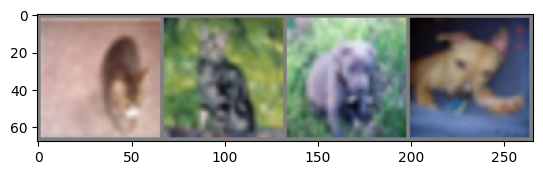

cat   cat   dog   dog  


In [3]:
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

(Self-check: You should see a grid of 4 images with their corresponding labels printed below.)

## Run the Provided Training Code
Now for the exciting part: defining and training our neural network! We'll create a simple Convolutional Neural Network (CNN) as it's well-suited for image classification.

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define our Convolutional Neural Network (CNN)
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # First convolutional layer
        # Input channels: 3 (for RGB images)
        # Output channels: 6
        # Kernel size: 5x5
        self.conv1 = nn.Conv2d(3, 6, 5)
        # Max pooling layer 1
        self.pool = nn.MaxPool2d(2, 2)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Fully connected layers
        # The input features to the first linear layer will depend on the
        # output size of the last pooling layer.
        # For 64x64 input images with two 2x2 max pools and two 5x5 convs,
        # the spatial dimensions become:
        # (64 - 5 + 1) / 2 = 30
        # (30 - 5 + 1) / 2 = 13
        # So, 16 channels * 13 * 13 features
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        self.fc2 = nn.Linear(120, 84)
        # Output layer: 2 classes (cat, dog)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the output for the fully connected layers
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# Move the network to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
print(f"Using device: {device}")

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print("Network defined, moved to device, and optimizer/loss defined!")

Using device: cpu
Network defined, moved to device, and optimizer/loss defined!


(Self-check: You should see messages confirming the network setup and the device being used.)

Now, let's train the network! This process will take some time, and you'll see the loss decreasing.

In [5]:
# Training loop
epochs = 10 # You can increase this for better accuracy, but it will take longer

print("Starting training...")
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Starting training...
[1,  2000] loss: 0.677
[2,  2000] loss: 0.642
[3,  2000] loss: 0.619
[4,  2000] loss: 0.583
[5,  2000] loss: 0.548
[6,  2000] loss: 0.503
[7,  2000] loss: 0.451
[8,  2000] loss: 0.388
[9,  2000] loss: 0.311
[10,  2000] loss: 0.231
Finished Training


**Watch**: See accuracy improve with training! As the training progresses, the loss value printed should generally decrease. This indicates that your model is learning and making better predictions.



## Test the Model with New, Unseen Images
After training, it's crucial to evaluate how well our model performs on data it has never seen before. This will give us a true measure of its generalization ability.

In [6]:
print("Starting testing...")

# Evaluate accuracy on the test set
correct = 0
total = 0
# Since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # Calculate outputs by running images through the network
        outputs = net(images)
        # The class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(testset)} test images: {100 * correct // total} %')

Starting testing...
Accuracy of the network on the 2000 test images: 70 %


(Self-check: You should see the accuracy percentage. A higher percentage means a better-performing model.)

Let's also see how the model performs on individual classes.

In [7]:
# Prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# Again, no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # Collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: cat   is 64.6 %
Accuracy for class: dog   is 76.0 %


(Self-check: You'll see the accuracy for 'cat' and 'dog' separately.)

Finally, let's visualize some predictions!

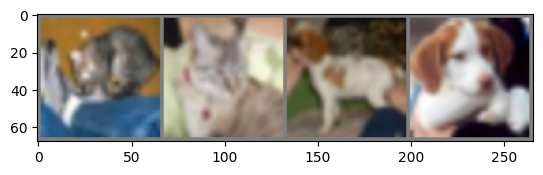

GroundTruth:  cat   cat   dog   dog  
Predicted:    dog   cat   dog   dog  


In [8]:
# Get some random test images and make predictions
dataiter = iter(testloader)
images, labels = next(dataiter)

# Move images to the device
images = images.to(device)

# Make predictions
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# Move images back to CPU for visualization
images = images.cpu()

# Show images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
print('Predicted:   ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

(Self-check: You'll see a grid of test images, their true labels, and what your model predicted. Observe how often your model gets it right!)

## Reflect and Discuss:
*   What was your overall accuracy?
*   Did you notice the loss decreasing during training?
*   Were there any images where the model made a wrong prediction?
*   Why do you think that might have happened?
* What are some ways we could try to improve the model's accuracy? (e.g., more data, different network architecture, more training epochs)